In [1]:
# Load modules 
%matplotlib inline

import os
import glob
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length
from nilearn.plotting import view_img_on_surf, view_img
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from scipy.stats import ttest_1samp
from scipy.signal import hilbert
import networkx as nx
from IPython.display import HTML


# dir for neural 
story_dir = '/mnt/c/Users/since/Dropbox/Lab/Projects/CJY/_DATA'
May_dir = '/mnt/c/Users/since/Desktop/KdramaMay/'

In [2]:
#Load brain mask
mask_dir = '/mnt/c/Users/since/Desktop/KdramaMay/analysis/roi_masks/BN_atlas_sub_hipp/DMN_HIPP_mask.nii.gz'
mask = Brain_Data(mask_dir)
mask_x = expand_mask(mask)
mask_x.to_nifti().shape

/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/image/resampling.py:616: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/masking.py:916: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


(91, 109, 91, 31)

In [3]:
subjects_va = [ '2', '3','4','5','6','7','8','10',
               '11','12','13','14','15','16','17','18','19','20',
               '21','22','23','24','25','27','28','29','30',
               '31','32','33']

subjects_av = ['34','35','38','39','40',
               '42','43','44','45','46','48','49',
               '51','52','53','54','55','58','59',
               '64','65','66','67','68','70',
               '71','72','73','74','75','76']
subjects = np.concatenate([subjects_va, subjects_av])
subjects

array(['2', '3', '4', '5', '6', '7', '8', '10', '11', '12', '13', '14',
       '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '27', '28', '29', '30', '31', '32', '33', '34', '35', '38', '39',
       '40', '42', '43', '44', '45', '46', '48', '49', '51', '52', '53',
       '54', '55', '58', '59', '64', '65', '66', '67', '68', '70', '71',
       '72', '73', '74', '75', '76'], dtype='<U2')

In [4]:
sub_timeseries = {}
for sub in subjects:
    run_timeseries = {} 
    for run in [1,2]: 
        run_timeseries[run] = pd.read_csv(os.path.join(May_dir, 'denoised','bn_subregion_masked', f'sub-{sub}_task-encoding_run-{run}_Average_ROI_BN_n28.csv'))
    sub_timeseries[sub] = run_timeseries

In [7]:
# LH와 RH 대응되는 ROI 쌍 매칭 리스트
roi_pairs = [
    (0, 14), (1, 15), (2, 16), (3, 13), (4, 17), (5, 18), (6, 19), (8, 20),
    (9, 21), (11, 22), (12, 23), (24, 25), (26, 27)]
roi_idx = [0,1,2,3,4,5,6,8,9,11,12,24,26]
roi_name=['MTG_1','MTG_2','MTG_3', 'AG', 'IFG_1', 'IFG_2','VMPFC','DMPFC', 
          'SFG_1','SFG_2','PMC','RSC', 'AHC','PHC']
          
# 첫 번째 실행 예시 데이터
concat_timeseries={}
for sub in subjects:
    run_concat_timeseries={}
    for run in [1,2]: 
        data = sub_timeseries[sub][run]
        avg_data = pd.DataFrame()
        
        for (lh_idx, rh_idx) in roi_pairs:
            # ROI 번호는 1부터 시작하므로 인덱스에 -1을 합니다.
            lh_column = data.iloc[:, lh_idx]
            rh_column = data.iloc[:, rh_idx]
            
            # 좌우 반구 평균을 구해서 새로운 데이터프레임에 추가
            avg_data[lh_idx] = (lh_column + rh_column) / 2
        
        # 평균이 적용된 새로운 데이터프레임을 출력 또는 저장
        run_concat_timeseries[run]=avg_data
    concat_timeseries[sub]=run_concat_timeseries

In [8]:
import scipy.io as sio

all_story = {}
# Load May Data
for sub in subjects:
    #print(sub)
    mat = sio.loadmat(glob.glob(os.path.join(story_dir, 'fMRItdsgn', f'sub-{sub}_*.mat'))[0])
    story = []
    for i in np.arange(0,4):
        temp = mat['subj'][0][0][7][0][i][0]
        if temp == 'Blind Date':
            temp = 'BlindDate'
        elif temp == 'Runningman':
            temp = 'RunningMan'
        elif temp == 'Way To School':
            temp = 'WayToSchool'
        elif temp == 'Business Lunch':
            temp = 'BusinessLunch'
        elif temp == 'neighbors':
            temp = 'Neighbors'
        story = np.append(story, temp)
    #all_story[str(int(sub)+8)] = story
    all_story[sub] = story
#Fix story sequence
story_sequece = all_story['2']
story_sequece

array(['Neighbors', 'Dream', 'BlindDate', 'RunningMan'], dtype='<U32')

In [9]:
# Data Load & Trimming 
onset = {'Dream1' : [0, 110, 230, 350], 'Dream2' : [0, 120, 230, 350], 'Dream3' : [0, 120, 240, 350], 'Dream4' : [0, 120, 240, 360]}
offset = {'Dream1' : [119, 239, 359, 477], 'Dream2' : [129, 239, 359, 477], 'Dream3' : [129, 249, 359, 477], 'Dream4' : [129, 249, 369, 477]} 

# May는 Dream의 위치에 따라 Trimming이 달라져야함.. ;D
storyName = {'RunningMan': 'run', 'BlindDate': 'blind', 'Dream':'dream', 'Neighbors':'nei'}

sub_story_timeseries = {}
for sub in subjects:
    story = {} 
    sequence = np.where(all_story[sub]=='Dream')[0][0]
    cond = 'Dream'+str(int(sequence)+1)
    if int(sub) < 34: 
        for i in np.arange(0,4):
            story[storyName[all_story[sub][i]]] = {'visual' : concat_timeseries[sub][1].iloc[onset[cond][i]:offset[cond][i]], 'audio' : concat_timeseries[sub][2].iloc[onset[cond][i]:offset[cond][i]]}
    else:
        for i in np.arange(0,4):
            story[storyName[all_story[sub][i]]] = {'audio' : concat_timeseries[sub][1].iloc[onset[cond][i]:offset[cond][i]], 'visual' : concat_timeseries[sub][2].iloc[onset[cond][i]:offset[cond][i]]}
    sub_story_timeseries[sub] = story

In [161]:
story_run_subjs_ROIs = {}
run1_ROIs = {} 
run2_ROIs = {} 
for roi in roi_idx:
    sub_rois = {}
    sub_run1_rois ={} 
    sub_run2_rois = {} 
    
    for sub in subjects_av:
        data1, data2 = {}, {}
        for j in ['run', 'blind', 'dream', 'nei']:
            data1[j] = sub_story_timeseries[sub][j]['visual'][roi].reset_index(drop=True)
            data2[j] = sub_story_timeseries[sub][j]['audio'][roi].reset_index(drop=True)

        # 시청각 데이터를 결합하여 모든 스토리 데이터를 하나로 만듭니다.
        all_data1 = pd.concat([data1['run'], data1['blind'], data1['dream'], data1['nei']]).reset_index(drop=True)  
        all_data2 = pd.concat([data2['run'], data2['blind'], data2['dream'], data2['nei']]).reset_index(drop=True) 
        story_data = pd.concat([all_data1, all_data2]).reset_index(drop=True)

        # 각 피험자의 데이터를 저장
        sub_rois[sub] = story_data
        sub_run1_rois[sub] = all_data1
        sub_run2_rois[sub] = all_data2
    # 각 ROI에 대한 모든 피험자의 데이터를 저장
    story_run_subjs_ROIs[roi] = sub_rois
    run1_ROIs[roi] = sub_run1_rois
    run2_ROIs[roi] = sub_run2_rois

In [17]:
# calculate inter-sc for each story 
#Segmentation for each story 
InterSC_r_va, InterSC_p_va = {}, {}
run1_InterSC_r_va, run1_InterSC_p_va = [], []
run2_InterSC_r_va, run2_InterSC_p_va = [], []
# for roi in range(31): 
#     stats = isc(pd.DataFrame(story_run_subjs_ROIs[roi]), n_bootstraps=10000, metric='median', method='bootstrap')
#     InterSC_r_va[roi], InterSC_p_va[roi]= stats['isc'], stats['p']
for roi in roi_idx:     
    stats = isc(pd.DataFrame(run1_ROIs[roi]), n_bootstraps=10000, metric='median', method='bootstrap')
    run1_InterSC_r_va.append(stats['isc'])
    run1_InterSC_p_va.append(stats['p'])
    
    stats = isc(pd.DataFrame(run2_ROIs[roi]), n_bootstraps=10000, metric='median', method='bootstrap')
    run2_InterSC_r_va.append(stats['isc'])
    run2_InterSC_p_va.append(stats['p'])

In [162]:
from brainiak.isc import isc

run1_InterSC_r_va, run1_InterSC_p_va = {},{}
run2_InterSC_r_va, run2_InterSC_p_va = {},{}
# ISC calculation for run1 and run2 data
for roi in roi_idx:  # If run1_ROIs and run2_ROIs have 28 ROIs
    try:
        # Run1 ISC
        run1_data = pd.DataFrame(run1_ROIs[roi])
        isc_values_run1 = isc(run1_data.values, pairwise=False, summary_statistic=None)
        run1_InterSC_r_va[roi] = isc_values_run1
        
        # Run2 ISC
        run2_data = pd.DataFrame(run2_ROIs[roi])
        isc_values_run2 = isc(run2_data.values, pairwise=False, summary_statistic=None)
        run2_InterSC_r_va[roi] = isc_values_run2
    except Exception as e:
        print(f"Error processing ROI {roi} in full story data: {e}")

In [104]:
sorted_roi_results

[(1, 'MTG_2', 0.22324960814414474, array([7.28936085e-15])),
 (0, 'MTG_1', 0.16786910404113212, array([4.68220803e-08])),
 (2, 'MTG_3', 0.10818638972416753, array([4.11869542e-06])),
 (9, 'SFG_1', 0.048534884909299754, array([0.00689936])),
 (12, 'RSC', 0.03272991225601347, array([0.12296192])),
 (24, 'AHC', 0.030050574073709046, array([0.10838363])),
 (3, 'AG', 0.010557901009908869, array([0.53370349])),
 (5, 'IFG_2', 0.005876560550114983, array([0.77997584])),
 (4, 'IFG_1', 0.004017786345210512, array([0.81317004])),
 (8, 'DMPFC', -0.020567747583696484, array([0.26860322])),
 (11, 'PMC', -0.03837007060173833, array([0.06631999])),
 (26, 'PHC', -0.06020382491146778, array([0.00071524])),
 (6, 'VMPFC', -0.07836282043575488, array([1.4130728e-05]))]

0 0
1 1
2 2
3 3
4 4
5 5
6 6
8 7
9 8
11 9
12 10
24 11
26 12


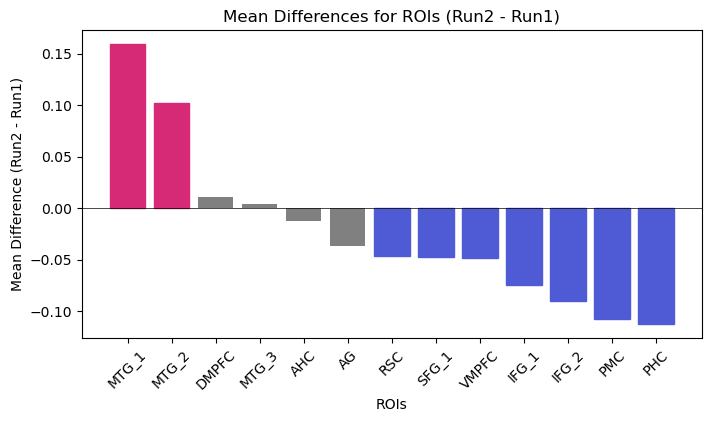

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp

# ROI 이름 리스트
roi_name=['MTG_1','MTG_2','MTG_3', 'AG', 'IFG_1', 'IFG_2','VMPFC','DMPFC', 
          'SFG_1','PMC','RSC', 'AHC','PHC']

x = roi_name

# 차이 계산 및 t-test 수행 결과 저장할 리스트
roi_results = []

# ROI 간의 차이 계산 및 t-test 수행
for r, roi in enumerate(roi_idx):
    print(roi,r)
    diff = np.array(run2_InterSC_r_va[roi]) - np.array(run1_InterSC_r_va[roi])

    # T-test 수행
    t_stat, p_value = ttest_1samp(diff, popmean=0)
    
    # ROI 이름, 평균 차이, p-value 저장
    roi_results.append((roi, x[r], diff.mean(), p_value))

# 평균값으로 정렬
sorted_roi_results = sorted(roi_results, key=lambda x: x[2], reverse=True)

# 그래프 그리기
sorted_rois = [result[1] for result in sorted_roi_results]  # ROI 이름
sorted_means = [result[2] for result in sorted_roi_results]  # 평균 차이
sorted_p_values = [result[3] for result in sorted_roi_results]  # p-value

# # 막대 그래프 그리기
plt.figure(figsize=(8, 4))
bars = plt.bar(sorted_rois, sorted_means, color='gray')

# 유의미한 차이를 가진 ROI 강조 (p-value < 0.05)
for bar, p_val, mean_diff in zip(bars, sorted_p_values, sorted_means):
    if p_val < 0.05 and mean_diff > 0:
        bar.set_color('#d62976')
    elif p_val < 0.05 and mean_diff < 0:
        bar.set_color('#4f5bd5')

# # X축 레이블 설정
plt.xticks(rotation=45)
plt.xlabel('ROIs')
plt.ylabel('Mean Difference (Run2 - Run1)')
plt.title('Mean Differences for ROIs (Run2 - Run1)')
plt.axhline(y=0, linewidth=0.5, color='black')


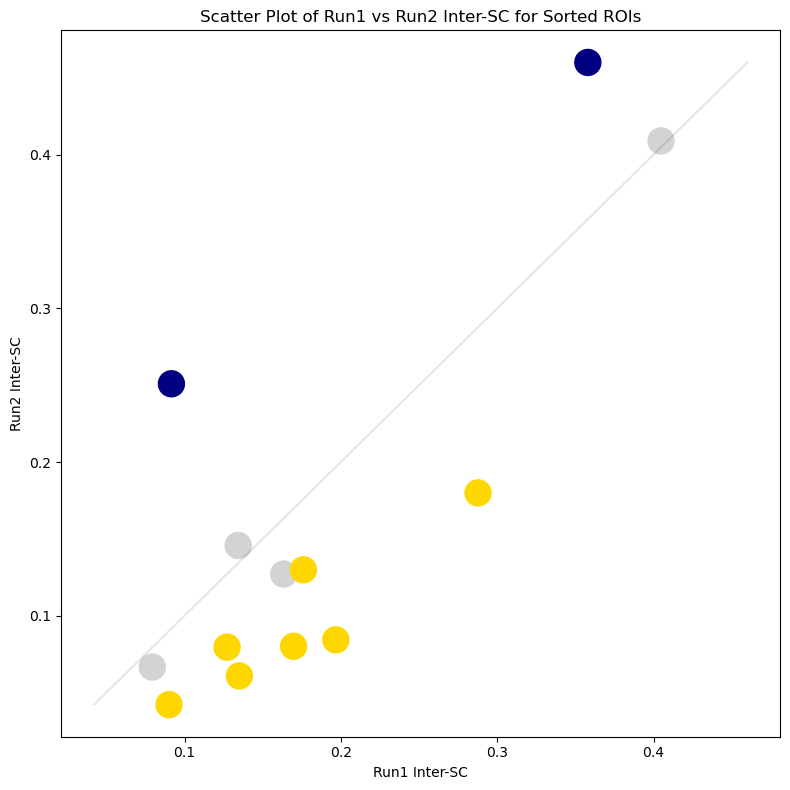

In [164]:
plt.figure(figsize=(8, 8))
sorted_run2_values = [run2_InterSC_r_va[roi].mean() for roi, _, _, _ in sorted_roi_results]
sorted_run1_values = [run1_InterSC_r_va[roi].mean() for roi, _, _, _ in sorted_roi_results]

# 각 점에 대해 색상 설정 (유의미한 차이에 따라 색상 맵핑)
colors = []
for p_val, mean_diff in zip(sorted_p_values, sorted_means):
    if p_val < 0.05 and mean_diff > 0:
        colors.append('navy')  # 양수일 때 파란색
    elif p_val < 0.05 and mean_diff < 0:
        colors.append('gold')  # 음수일 때 빨간색
    else:
        colors.append('lightgray')  # 유의하지 않을 때 회색

# 산포도 그리기
plt.scatter(sorted_run1_values, sorted_run2_values, color=colors, s=350)

# y=x 선 추가 (직선 그리기)
min_val = min(min(sorted_run1_values), min(sorted_run2_values))
max_val = max(max(sorted_run1_values), max(sorted_run2_values))
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', alpha = 0.1)

# X축과 Y축 설정
plt.xlabel('Run1 Inter-SC')
plt.ylabel('Run2 Inter-SC')
# plt.ylim([0.02, 0.5])
# plt.xlim([0.02, 0.5])

# 제목과 범례 추가
plt.title('Scatter Plot of Run1 vs Run2 Inter-SC for Sorted ROIs')

# 그래프 표시
plt.tight_layout()
plt.savefig(f"ISC_av.jpg")
plt.show()

# make brain map

In [120]:
from nltools.mask import expand_mask, collapse_mask

mask_dir = '/mnt/c/Users/since/Desktop/KdramaMay/analysis/roi_masks/BN_atlas_sub_hipp/DMN_HIPP_mask.nii.gz'
mask = Brain_Data(mask_dir)
mask_x = expand_mask(mask)

/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/image/resampling.py:616: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)


In [121]:
mask_x.to_nifti().get_fdata().shape

/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/masking.py:916: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


(91, 109, 91, 31)

In [152]:
from nilearn import plotting, datasets, surface
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nltools.data import Brain_Data
from matplotlib.colors import ListedColormap

# Define the sets of ROIs
yellow_rois= [0, 1 ]  # Blue color ROIs
blue_rois = [12,9,4,5,11,6,26]  # Pink color ROIs

# Initialize combined mask data
affine = mask_x[0].to_nifti().affine
combined_mask_data = np.zeros_like(mask_x[0].to_nifti().get_fdata())  # Initialize an empty 3D array


# # Assign values to the pink ROIs
for roi in blue_rois:
    roi_mask = mask_x[roi].to_nifti().get_fdata()  # Convert to array
    roi_mask[roi_mask > 0] = 2 # Assign pink ROI value
    combined_mask_data[roi_mask > 0] = 10  # Update combined mask
combined_mask_nifti_blue = nib.Nifti1Image(combined_mask_data.astype(np.int32), affine)
combined_mask_data = np.zeros_like(mask_x[0].to_nifti().get_fdata())  # Initialize an empty 3D array

# Assign values to the blue ROIs
for roi in yellow_rois:
    roi_mask = mask_x[roi].to_nifti().get_fdata()  # Convert to array
    roi_mask[roi_mask > 0] = 1 # Assign blue ROI value
    combined_mask_data[roi_mask > 0] = - 5 # Update combined mask
combined_mask_nifti_yellow = nib.Nifti1Image(combined_mask_data.astype(np.int32), affine)
# combined_mask_nifti_pink.append(combined_mask_nifti_blue)

/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/masking.py:916: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/masking.py:916: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


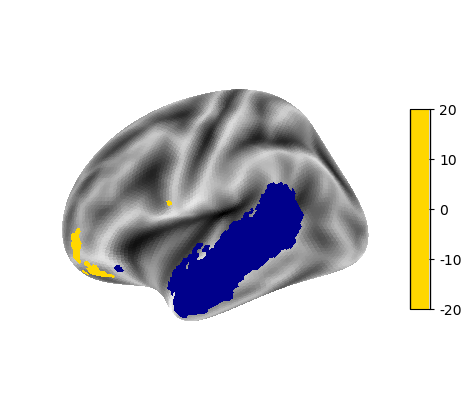

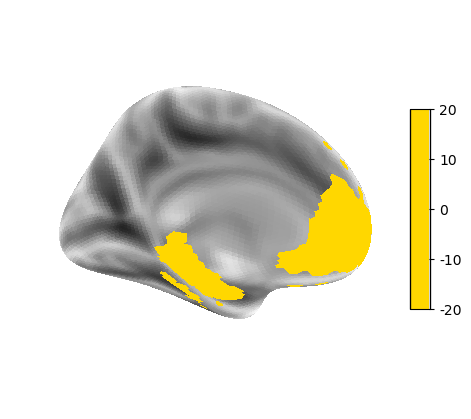

In [151]:

bn_mask = Brain_Data([combined_mask_nifti_yellow,combined_mask_nifti_blue])
mask_c = collapse_mask(bn_mask)

# Visualization settings
threshold = 0.1
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5')

# Generate "texture" for left and right hemispheres
texture_left_combined = surface.vol_to_surf(mask_c.to_nifti(), fsaverage.pial_left)
texture_right_combined = surface.vol_to_surf(mask_c.to_nifti(), fsaverage.pial_right)

# Define custom colormap (blue for 1, pink for 2)
colors = ['#00008B','#FFD700',]  # Blue and yellow
cmap = ListedColormap(colors)

# Plot both ROIs on the left hemisphere
plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture_left_combined, 
    hemi='left', view='lateral', 
    cmap=cmap,threshold=threshold, 
    bg_map=fsaverage.sulc_left)
plt.savefig(f"brain1_va.jpg")

plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture_left_combined, 
    hemi='left', view='medial', 
    cmap=cmap, threshold=threshold, 
    bg_map=fsaverage.sulc_left)
plt.savefig(f"brain2_va.jpg")
# # Plot both ROIs on the right hemisphere
# plotting.plot_surf_stat_map(
#     fsaverage.infl_right, texture_right_combined, 
#     hemi='right', view='lateral', 
#     cmap=cmap, threshold=threshold, 
#     bg_map=fsaverage.sulc_right)

# plotting.plot_surf_stat_map(
#     fsaverage.infl_right, texture_right_combined, 
#     hemi='right', view='medial', 
#     cmap=cmap, threshold=threshold, 
#     bg_map=fsaverage.sulc_right)

plt.show()


/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/masking.py:916: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/masking.py:916: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


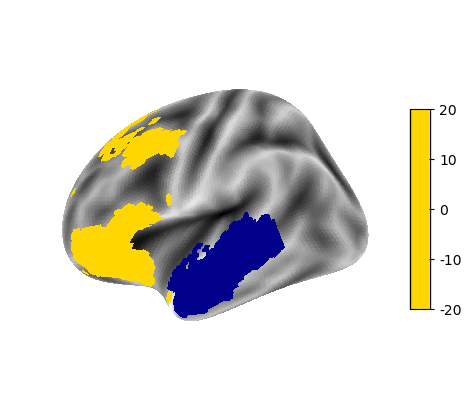

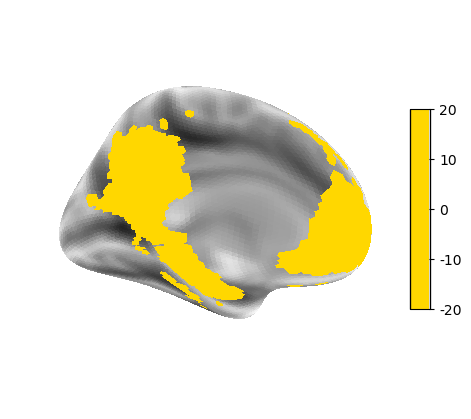

In [155]:

bn_mask = Brain_Data([combined_mask_nifti_yellow,combined_mask_nifti_blue])
mask_c = collapse_mask(bn_mask)

# Visualization settings
threshold = 0.1
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5')

# Generate "texture" for left and right hemispheres
texture_left_combined = surface.vol_to_surf(mask_c.to_nifti(), fsaverage.pial_left)
texture_right_combined = surface.vol_to_surf(mask_c.to_nifti(), fsaverage.pial_right)

# Define custom colormap (blue for 1, pink for 2)
colors = ['#00008B','#FFD700',]  # Blue and yellow
cmap = ListedColormap(colors)

# Plot both ROIs on the left hemisphere
plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture_left_combined, 
    hemi='left', view='lateral', 
    cmap=cmap,threshold=threshold, 
    bg_map=fsaverage.sulc_left)
plt.savefig(f"brain1_av.jpg")

plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture_left_combined, 
    hemi='left', view='medial', 
    cmap=cmap, threshold=threshold, 
    bg_map=fsaverage.sulc_left)
plt.savefig(f"brain2_av.jpg")
# # Plot both ROIs on the right hemisphere
# plotting.plot_surf_stat_map(
#     fsaverage.infl_right, texture_right_combined, 
#     hemi='right', view='lateral', 
#     cmap=cmap, threshold=threshold, 
#     bg_map=fsaverage.sulc_right)

# plotting.plot_surf_stat_map(
#     fsaverage.infl_right, texture_right_combined, 
#     hemi='right', view='medial', 
#     cmap=cmap, threshold=threshold, 
#     bg_map=fsaverage.sulc_right)

plt.show()
